In this notebook we prepare the plots for virtual telescope for the final presentation

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from sdo.pytorch_utilities import init_gpu, set_seed
from sdo.models.vt_encoder_decoder import VT_EncoderDecoder
from sdo.models.vt_basic_encoder import VT_BasicEncoder

from sdo.datasets.virtual_telescope_sdo_dataset import VirtualTelescopeSDO_Dataset

from sdo.viz.plot_vt_outputs import plot_difference
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
experiment_name = 'v_experiment_3'
epoch = 2000
vt_dir ='/gpfs/gpfs_gl4_16mb/b9p111/fdl_sw/experiments_results_vt/'
experiment = '{}/{}_{}_model.pth'.format(experiment_name, epoch, experiment_name)
path_model = os.path.join(vt_dir, experiment)
plot_dir = '/gpfs/gpfs_gl4_16mb/b9p111/b9p111ap/results/plots/'

## Load the model

In [3]:
device = init_gpu()
set_seed()

In [6]:
scaled_height = 128
scaled_width = 128
channels = ['0094', '0171', '0193', '0211']
num_channels = len(channels) - 1

model = VT_BasicEncoder(input_shape=[num_channels, scaled_height, scaled_width])
model.cuda(device)
model.eval()

VT_EncoderDecoder architecture:
Input shape: [3, 128, 128]
Input dim  : 49152
Learnable params: 2305


VT_BasicEncoder(
  (conv1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [7]:
state_dict = torch.load(path_model)
model.load_state_dict(state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Load one batch

In [9]:
batch_size_test = 5
tolerance = 0.05

# in the model above we trained on "0094","0171","0193" and predicted "0211"
test_dataset = VirtualTelescopeSDO_Dataset(num_channels+1,
                                 instr=["AIA"] * (num_channels+1),
                                 channels=[
                                     "0094",
                                     "0171",
                                     "0193",
                                     "0211"],
                                 yr_range=[2013, 2014],
                                 mnt_step=1,
                                 day_step=1,
                                 h_step=6,
                                 min_step=60,
                                 resolution=512,
                                 subsample=4,
                                 normalization=0,
                                 scaling=True,
                                 shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test)

Shuffling is being applied, this will alter the time sequence.


In [10]:
# extract the first batch
examples = enumerate(test_loader)
batch_idx, (input_data, gt_output, _) = next(examples)

In [11]:
all_input = []
all_gt_output = []
all_output = []

input_data = input_data.to(device)
gt_output = gt_output.to(device)
output = model(input_data)

input_data = input_data.cpu().detach().numpy()
output = output.cpu().detach().numpy()
gt_output = gt_output.cpu().detach().numpy()

# Prediction - Channels #

In [14]:
gt_output_t = gt_output[0,0,:,:]
output_t = output[0,0,:,:]
input_data_t = input_data[0,:,:,:]

In [12]:
def plot_difference_input_gt(img_gt, input_channels, channels, img_file=None):
    
    channels_mean =np.mean(input_channels, axis=0)

    fig, axs = plt.subplots(1, 4, figsize=(18, 5), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    GT = channels[-1]
    for i, ch in enumerate(channels[:-1]):
        im = axs[i].imshow((input_channels[i,:,:] - img_gt),cmap='seismic', vmin=-1, vmax=1, origin='lower')
        axs[i].set_title('AIA {} - AIA {}'.format(ch, GT))
        
    im = axs[i+1].imshow((channels_mean - img_gt),cmap='seismic', vmin=-1, vmax=1, origin='lower')
    axs[i+1].set_title('Mean inputs - AIA {}'.format(GT))
    
    fig.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
    # distance from left border, space from bottom, bar width, space from top
    cbar_ax = fig.add_axes([0.82, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    
    if img_file:
        plt.savefig(img_file, bbox_inches='tight')
        plt.close()

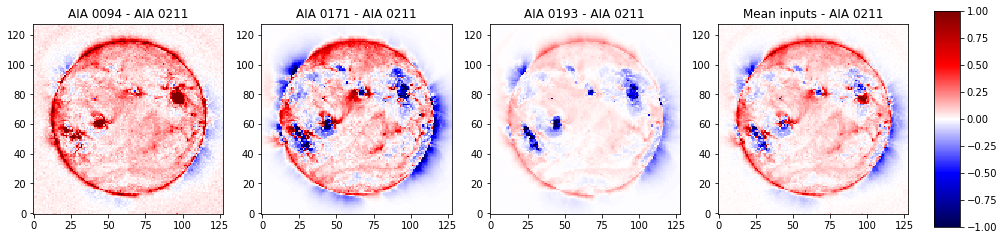

In [15]:
img_file = 'input_GT_{}.png'.format(experiment_name)
img_file = plot_dir + img_file
plot_difference_input_gt(gt_output_t, input_data_t, channels, img_file=img_file)

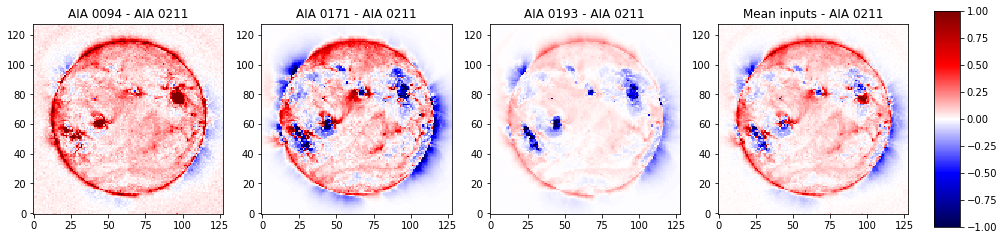

In [16]:
plot_difference_input_gt(gt_output_t, input_data_t, channels)

In [17]:
def plot_difference_pred_gt(img_gt, img_pred, channel, img_file=None):
    fig, axs = plt.subplots(1, 3, figsize=(16, 16), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    im = axs[0].imshow(img_gt, origin='lower', vmin=0, vmax=2, cmap='hot')
    axs[0].set_title('Real AIA {}'.format(channel))
    
    im = axs[1].imshow((img_pred - img_gt), cmap='seismic', vmin=-1, vmax=1, origin='lower')
    axs[1].set_title('Real - Generated AIA {}'.format(channel))
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
        
    im = axs[2].imshow(img_pred, origin='lower', vmin=0, vmax=2, cmap='hot')
    axs[2].set_title('Generated AIA {}'.format(channel))
    
    if img_file:
        plt.savefig(img_file, bbox_inches='tight')
        plt.close()

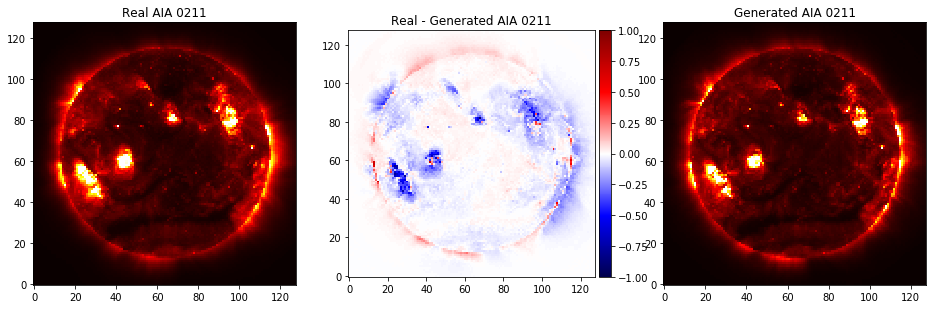

In [18]:
plot_difference_pred_gt(gt_output_t, output_t, channels[-1])

In [19]:
img_file = 'pred_GT_{}.png'.format(experiment_name)
img_file = plot_dir + img_file
plot_difference_pred_gt(gt_output_t, output_t, channels[-1], img_file=img_file)

In [30]:
def plot_original_input(img_gt, input_channels, channels, img_file=None):
    fig, axs = plt.subplots(1, 4, figsize=(18, 5), facecolor='w', edgecolor='k')
    
    axs = axs.ravel()
    for i, ch in enumerate(channels[:-1]):
        im = axs[i].imshow(input_channels[i,:,:], cmap='hot', vmin=0, vmax=2, origin='lower')
        axs[i].set_title('AIA {}'.format(ch))
    im = axs[i+1].imshow(img_gt, cmap='hot', vmin=0, vmax=2, origin='lower')
    axs[i+1].set_title('AIA {}'.format(channels[-1]))    
    
    if img_file:
        plt.savefig(img_file, bbox_inches='tight')
        plt.close()

In [33]:
img_file = 'original_images_{}.png'.format(experiment_name)
img_file = plot_dir + img_file
plot_original_input(gt_output_t, input_data_t, channels, img_file=img_file)